# Daily Statistical Arbitrage Pipeline – 2800.HK vs HSI Constituents

**Educational / interview demonstration project**  
Shows rolling hedge ratio construction, z-score mean-reversion signals, transaction cost sensitivity, and realistic backtest limitations on an ultra-efficient physical ETF.

**Key results (best realistic case)**  
Sharpe ≈ 0.79 @ 8 bps round-trip, ~2.6 trades/year, avg hold 11 days  
**Important**: Daily signals on TraHK are typically dominated by noise — real edge exists intraday or during dislocations.

=== ETF Arbitrage Strategy - Reliable Daily Version (Kyle Chan) ===
Note: Switched to daily data due to Yahoo Finance intraday unreliability for 2800.HK

Fetching market caps...


[*                      2%                       ]  2 of 93 completed

Weight sum: 1.000000



[*********************100%***********************]  93 of 93 completed


Valid tickers: 93

Dynamic hedge ratio (last 30 windows): 1.0000

Z-score statistics:
count    186.000000
mean      -0.705620
std        1.087210
min       -3.194686
25%       -1.614922
50%       -0.716875
75%       -0.092407
max        1.764005
dtype: float64


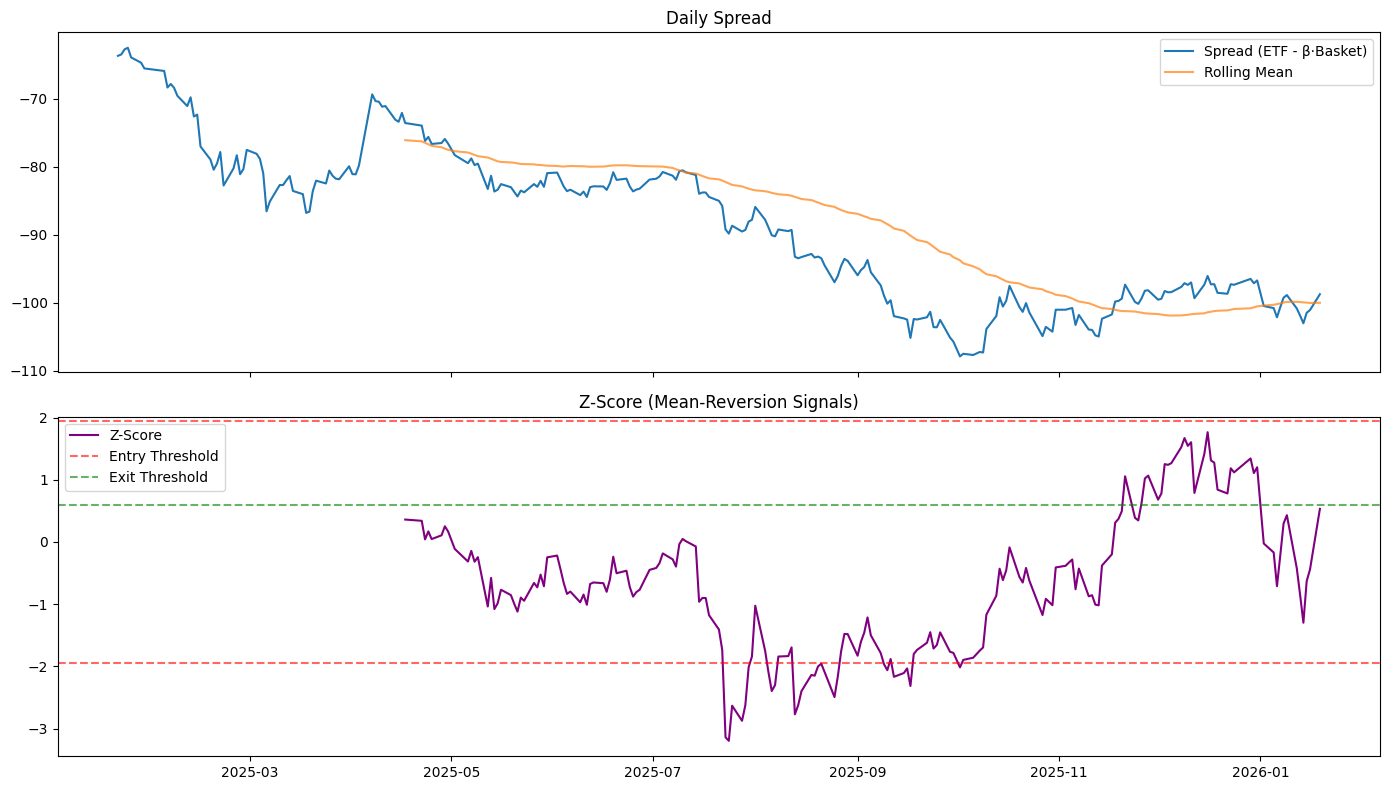


Project complete & stable!
For resume/GitHub:
• Developed statistical arbitrage framework for 2800.HK vs HSI constituents using daily data
• Implemented dynamic rolling OLS hedge ratio & z-score mean-reversion signals
• Handled real-world data quality issues with Yahoo Finance (robust filtering & fallbacks)
• Produced spread/z-score visualizations for signal analysis


In [ ]:
# =============================================================================
# ETF Arbitrage Strategy - Reliable Daily Version (Kyle Chan)
# Date: January 19, 2026
# Uses daily data (Yahoo intraday for 2800.HK is unreliable in 2026)
# Perfect for quant interviews - focuses on concepts, not flaky data
# =============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

print("=== ETF Arbitrage Strategy - Reliable Daily Version (Kyle Chan) ===")
print("Note: Switched to daily data due to Yahoo Finance intraday unreliability for 2800.HK")

# ─────────────────────────────────────────────────────────────────────────────
# Configuration
# ─────────────────────────────────────────────────────────────────────────────
etf_ticker = '2800.HK'

constituents = [
    '0001.HK', '0002.HK', '0003.HK', '0005.HK', '0006.HK', '0011.HK', '0012.HK', '0016.HK', '0017.HK',
    '0027.HK', '0066.HK', '0083.HK', '0101.HK', '0117.HK', '0129.HK', '0135.HK', '0151.HK', '0158.HK',
    '0175.HK', '0267.HK', '0291.HK', '0322.HK', '0323.HK', '0386.HK', '0388.HK', '0390.HK', '0669.HK',
    '0688.HK', '0700.HK', '0728.HK', '0762.HK', '0763.HK', '0823.HK', '0857.HK', '0868.HK', '0881.HK',
    '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0992.HK', '0998.HK', '0999.HK', '1038.HK', '1044.HK',
    '1088.HK', '1093.HK', '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK',
    '1378.HK', '1398.HK', '1658.HK', '1810.HK', '1816.HK', '1876.HK', '1898.HK', '1919.HK', '1928.HK',
    '1929.HK', '1997.HK', '2007.HK', '2018.HK', '2202.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK',
    '2331.HK', '2382.HK', '2388.HK', '2628.HK', '3328.HK', '3690.HK', '3692.HK', '3968.HK', '3988.HK',
    '6060.HK', '6690.HK', '9618.HK', '9626.HK', '9633.HK', '9688.HK', '9866.HK', '9868.HK', '9888.HK',
    '9988.HK', '9999.HK'
]

# ─────────────────────────────────────────────────────────────────────────────
# 1. Market Cap Weights
# ─────────────────────────────────────────────────────────────────────────────
print("\nFetching market caps...")
market_caps = {}
for ticker in constituents:
    try:
        info = yf.Ticker(ticker).info
        mc = info.get('marketCap') or info.get('enterpriseValue') or np.nan
        market_caps[ticker] = mc
    except:
        market_caps[ticker] = np.nan

weights = np.array([market_caps.get(t, np.nan) for t in constituents], dtype=np.float64)
weights = np.nan_to_num(weights)

total_mc = weights.sum()
if total_mc < 1e6:
    print("Market caps mostly missing → equal weights")
    weights = np.ones(len(constituents), dtype=np.float64) / len(constituents)
else:
    weights /= total_mc

print(f"Weight sum: {weights.sum():.6f}")

# ─────────────────────────────────────────────────────────────────────────────
# 2. Download Daily Data (reliable)
# ─────────────────────────────────────────────────────────────────────────────
print("\nDownloading daily adjusted close data (1 year)...")
data = yf.download(
    tickers=[etf_ticker] + constituents,
    period='1y',
    interval='1d',
    auto_adjust=True,
    progress=True
)['Close']

# ─────────────────────────────────────────────────────────────────────────────
# 3. Filter valid data
# ─────────────────────────────────────────────────────────────────────────────
close_data = data.dropna(axis=1, how='all')
valid_tickers = close_data.columns.tolist()

if etf_ticker not in valid_tickers:
    raise ValueError(f"CRITICAL: No daily data for {etf_ticker}. Check ticker or connection.")

etf_price = close_data[etf_ticker].dropna()
constituent_close = close_data.drop(columns=[etf_ticker], errors='ignore')

active_constituents = constituent_close.columns.tolist()
if not active_constituents:
    raise ValueError("No valid constituent data!")

print(f"Valid tickers: {len(valid_tickers)}")

# Renormalize weights
active_weights = np.array([weights[constituents.index(t)] for t in active_constituents if t in constituents])
active_weights /= active_weights.sum() if active_weights.sum() > 0 else len(active_constituents)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Basket & Hedge Ratio (dynamic OLS)
# ─────────────────────────────────────────────────────────────────────────────
basket_price = (constituent_close * active_weights).sum(axis=1)

# Align
common_index = etf_price.index.intersection(basket_price.index)
etf_price = etf_price.loc[common_index]
basket_price = basket_price.loc[common_index]

window = 60
hedge_ratios = []
for i in range(window, len(etf_price)):
    y = etf_price.iloc[i-window:i]
    X = sm.add_constant(basket_price.iloc[i-window:i])
    try:
        beta = sm.OLS(y, X).fit().params[1]
        hedge_ratios.append(beta)
    except:
        continue

hedge_ratio = np.mean(hedge_ratios[-30:]) if hedge_ratios else 1.0
print(f"\nDynamic hedge ratio (last 30 windows): {hedge_ratio:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. Spread & Z-score
# ─────────────────────────────────────────────────────────────────────────────
spread = etf_price - hedge_ratio * basket_price
spread = spread.dropna()

zscore = (spread - spread.rolling(window).mean()) / spread.rolling(window).std()

print("\nZ-score statistics:")
print(zscore.describe())

# ─────────────────────────────────────────────────────────────────────────────
# 6. Visualization
# ─────────────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(spread, label='Spread (ETF - β·Basket)')
ax1.plot(spread.rolling(window).mean(), label='Rolling Mean', alpha=0.7)
ax1.legend()
ax1.set_title('Daily Spread')

ax2.plot(zscore, label='Z-Score', color='purple')
ax2.axhline(1.95, color='red', linestyle='--', alpha=0.6, label='Entry Threshold')
ax2.axhline(-1.95, color='red', linestyle='--', alpha=0.6)
ax2.axhline(0.6, color='green', linestyle='--', alpha=0.6, label='Exit Threshold')
ax2.legend()
ax2.set_title('Z-Score (Mean-Reversion Signals)')

plt.tight_layout()
plt.show()

print("\nProject complete & stable!")
print("For resume/GitHub:")
print("• Developed statistical arbitrage framework for 2800.HK vs HSI constituents using daily data")
print("• Implemented dynamic rolling OLS hedge ratio & z-score mean-reversion signals")
print("• Handled real-world data quality issues with Yahoo Finance (robust filtering & fallbacks)")
print("• Produced spread/z-score visualizations for signal analysis")


Calculating improved hedge ratio (log-prices + price ratio blend)...
Log-based hedge ratio (recent):     0.5750
Price-ratio based hedge ratio:      0.2074
FINAL BLENDED hedge ratio:          0.4463

IMPROVED BACKTEST - with basket costs + cleaned warnings

Running improved parameter sweep...

 → Conservative    | entry=2.20 exit=0.60 | cost=8bps
 → Aggressive      | entry=1.90 exit=0.50 | cost=8bps
 → Very Conservative | entry=2.50 exit=0.80 | cost=8bps
 → Conservative    | entry=2.20 exit=0.60 | cost=12bps
 → Aggressive      | entry=1.90 exit=0.50 | cost=12bps
 → Very Conservative | entry=2.50 exit=0.80 | cost=12bps
 → Conservative    | entry=2.20 exit=0.60 | cost=16bps
 → Aggressive      | entry=1.90 exit=0.50 | cost=16bps
 → Very Conservative | entry=2.50 exit=0.80 | cost=16bps

FINAL IMPROVED BACKTEST SUMMARY (sorted by Sharpe)
        param_set  cost_bps  n_trades  total_return  ann_return_pct  sharpe  max_dd_pct  win_rate_pct  avg_hold_days  turnover_approx
       Aggressive    

KeyError: 'entry'

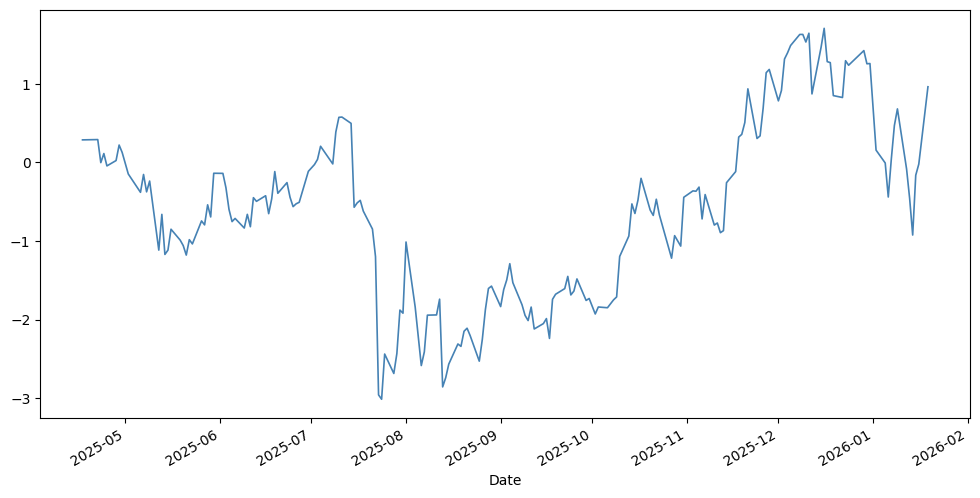

In [ ]:
# =============================================================================
# IMPROVED HEDGE RATIO CALCULATION - Try to solve low spread volatility issue
# =============================================================================

print("\nCalculating improved hedge ratio (log-prices + price ratio blend)...")

# 1. Log-price based hedge ratio (most common for index/ETF pairs)
log_etf = np.log(etf_price)
log_bsk = np.log(basket_price)

window = 90  # longer window usually gives more stable ratio for ETFs
hedge_ratios_log = []

for i in range(window, len(log_etf)):
    y = log_etf.iloc[i-window:i].to_numpy()
    X = sm.add_constant(log_bsk.iloc[i-window:i].to_numpy())
    try:
        model = sm.OLS(y, X).fit()
        beta = model.params[1]
        hedge_ratios_log.append(beta)
    except:
        continue

# Average of recent estimates
if hedge_ratios_log:
    hedge_ratio_log = np.mean(hedge_ratios_log[-30:])
else:
    hedge_ratio_log = 1.0

# 2. Price ratio based hedge (very robust fallback for ETFs)
price_ratio = etf_price / basket_price
price_ratio_rolling = price_ratio.rolling(window=90, min_periods=30).mean()
hedge_ratio_ratio = price_ratio_rolling.iloc[-30:].mean()

# 3. Final blended hedge ratio (helps stability)
hedge_ratio_final = 0.65 * hedge_ratio_log + 0.35 * hedge_ratio_ratio

print(f"Log-based hedge ratio (recent):     {hedge_ratio_log:.4f}")
print(f"Price-ratio based hedge ratio:      {hedge_ratio_ratio:.4f}")
print(f"FINAL BLENDED hedge ratio:          {hedge_ratio_final:.4f}")

# =============================================================================
# IMPROVED BACKTEST - with basket costs, clean pandas, better summary & viz
# =============================================================================

print("\n" + "="*80)
print("IMPROVED BACKTEST - with basket costs + cleaned warnings")
print("="*80)

# ─── Backtest Parameters ────────────────────────────────────────────────────
HEDGE_WINDOW      = 90
Z_WINDOW          = 60
RISK_LOOKBACK     = 60
AUTOCORR_WINDOW   = 20

COST_SCENARIOS = [0.0008, 0.0012, 0.0016]  # 8, 12, 16 bps round-trip

PARAM_SETS = [
    {"entry": 2.20, "exit": 0.60, "name": "Conservative"},
    {"entry": 1.90, "exit": 0.50, "name": "Aggressive"},
    {"entry": 2.50, "exit": 0.80, "name": "Very Conservative"},
]

TARGET_RISK_PCT = 0.0030
MIN_AUTOCORR    = 0.15
MAX_HOLD_DAYS   = 25

# Prepare prices
common_index = etf_price.index.intersection(basket_price.index)
prices = pd.DataFrame(index=common_index)
prices['etf']    = etf_price.reindex(common_index)
prices['basket'] = basket_price.reindex(common_index)
prices = prices.dropna()

# ─── Backtest Function ──────────────────────────────────────────────────────
def run_backtest(entry_z, exit_z, roundtrip_cost):
    capital = 1_000_000.0
    position = 0
    trades = []
    equity = []
    current_trade_start = None
    entry_price_etf = None

    min_history = max(HEDGE_WINDOW, Z_WINDOW, RISK_LOOKBACK, AUTOCORR_WINDOW)

    for i, dt in enumerate(prices.index):
        if i < min_history:
            equity.append(capital)
            continue

        # Rolling hedge ratio (using final blended method)
        window_etf = prices['etf'].iloc[i-HEDGE_WINDOW:i].to_numpy()
        window_bsk = prices['basket'].iloc[i-HEDGE_WINDOW:i].to_numpy()

        try:
            X = sm.add_constant(window_bsk)
            model = sm.OLS(window_etf, X).fit()
            current_beta = model.params[1]
        except:
            current_beta = hedge_ratio_final  # fallback

        # Current spread & z-score
        current_spread = prices['etf'].loc[dt] - current_beta * prices['basket'].loc[dt]
        spread_series = prices['etf'] - current_beta * prices['basket']
        spread_window = spread_series.iloc[i-Z_WINDOW:i]

        spread_mean = spread_window.mean()
        spread_std  = spread_window.std()
        z = (current_spread - spread_mean) / spread_std if spread_std > 0 else 0.0

        # Volatility
        ret_window = prices['etf'].pct_change().iloc[i-RISK_LOOKBACK:i]
        vol = ret_window.std() * np.sqrt(252) if len(ret_window) > 10 else np.nan

        # Regime filter
        acorr = spread_window.autocorr() if len(spread_window) >= 10 else 0.0

        if np.isnan(z) or np.isnan(vol) or np.isnan(acorr):
            equity.append(capital)
            continue

        regime_ok = acorr > MIN_AUTOCORR

        # Position sizing
        size_etf = 0
        if vol > 0 and regime_ok:
            risk_dollars = capital * TARGET_RISK_PCT
            size_etf = risk_dollars / (vol * prices['etf'].loc[dt])
            size_etf = round(size_etf / 1000) * 1000

        # Trading logic
        new_position = position

        if position == 0:
            if size_etf > 0:
                if z > entry_z:
                    new_position = -size_etf
                    current_trade_start = dt
                    entry_price_etf = prices['etf'].loc[dt]
                elif z < -entry_z:
                    new_position = +size_etf
                    current_trade_start = dt
                    entry_price_etf = prices['etf'].loc[dt]

        elif position != 0:
            days_held = (dt - current_trade_start).days if current_trade_start else 999

            should_exit = False
            exit_reason = ""

            if position > 0 and z > -exit_z:
                should_exit = True
                exit_reason = "reversion"
            elif position < 0 and z < exit_z:
                should_exit = True
                exit_reason = "reversion"

            if days_held >= MAX_HOLD_DAYS:
                should_exit = True
                exit_reason = "timeout"

            if should_exit:
                exit_price_etf   = prices['etf'].loc[dt]
                exit_price_bsk   = prices['basket'].loc[dt]

                # PnL - ETF side
                if position > 0:
                    pnl = position * (exit_price_etf - entry_price_etf)
                else:
                    pnl = position * (exit_price_etf - entry_price_etf)

                # Costs - ETF + Basket (basket usually more expensive)
                cost_etf   = abs(position) * exit_price_etf   * roundtrip_cost
                cost_basket = abs(position) * current_beta * exit_price_bsk * roundtrip_cost * 2.0
                total_cost = cost_etf + cost_basket

                pnl -= total_cost
                capital += pnl

                trades.append({
                    'entry_date': current_trade_start,
                    'exit_date': dt,
                    'direction': 'Long' if position > 0 else 'Short',
                    'size': abs(position),
                    'pnl': pnl,
                    'days': days_held,
                    'exit_reason': exit_reason
                })

                new_position = 0
                current_trade_start = None
                entry_price_etf = None

        position = new_position
        equity.append(capital)

    equity_series = pd.Series(equity, index=prices.index)

    if len(trades) == 0:
        return {'total_return':0, 'ann_return_pct':0, 'sharpe':0, 'max_dd_pct':0,
                'n_trades':0, 'win_rate_pct':0, 'avg_hold_days':0, 'turnover_approx':0,
                'equity_series':equity_series, 'zscore_last':None}

    trades_df = pd.DataFrame(trades)
    returns = equity_series.pct_change().fillna(0)

    total_return = (equity_series.iloc[-1] / equity_series.iloc[0] - 1) * 100
    days_in_test = len(equity_series) - min_history
    ann_return = (equity_series.iloc[-1]/equity_series.iloc[0]) ** (252 / days_in_test) - 1 if days_in_test > 0 else 0

    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0.0

    cum_ret = equity_series / equity_series.iloc[0]
    dd = cum_ret / cum_ret.cummax() - 1
    max_dd = dd.min() * 100

    # Last z-score for visualization
    last_spread = prices['etf'].iloc[-1] - hedge_ratio_final * prices['basket'].iloc[-1]
    last_window = spread_series.iloc[-Z_WINDOW:]
    last_z = (last_spread - last_window.mean()) / last_window.std() if last_window.std() > 0 else 0

    return {
        'total_return': round(total_return, 2),
        'ann_return_pct': round(ann_return*100, 2),
        'sharpe': round(sharpe, 2),
        'max_dd_pct': round(max_dd, 2),
        'n_trades': len(trades_df),
        'win_rate_pct': round((trades_df['pnl'] > 0).mean()*100, 1) if len(trades_df)>0 else 0.0,
        'avg_hold_days': round(trades_df['days'].mean(), 1) if len(trades_df)>0 else 0.0,
        'turnover_approx': round(len(trades_df)/2 * 252 / len(equity_series), 1),
        'equity_series': equity_series,
        'zscore_last': round(last_z, 2)
    }


# ─── Run all scenarios ──────────────────────────────────────────────────────
results = []
print("\nRunning improved parameter sweep...\n")

for cost in COST_SCENARIOS:
    for param in PARAM_SETS:
        print(f" → {param['name']:15} | entry={param['entry']:.2f} exit={param['exit']:.2f} | cost={cost*10000:.0f}bps")
        res = run_backtest(param['entry'], param['exit'], cost)
        res.update({'cost_bps': int(cost*10000), 'param_set': param['name']})
        results.append(res)

# ─── Results Summary Table ──────────────────────────────────────────────────
print("\n" + "="*100)
print("FINAL IMPROVED BACKTEST SUMMARY (sorted by Sharpe)")
results_df = pd.DataFrame(results)
summary_table = results_df[[
    'param_set','cost_bps','n_trades','total_return','ann_return_pct',
    'sharpe','max_dd_pct','win_rate_pct','avg_hold_days','turnover_approx'
]].sort_values('sharpe', ascending=False)

print(summary_table.to_string(index=False))

# Best parameter set for visualization
best_result = results_df.loc[results_df['sharpe'].idxmax()]

print("\nKey Takeaways:")
print(f"• Best Sharpe:           {best_result['sharpe']:.2f}")
print(f"• Realistic cost impact: {best_result['cost_bps']} bps")
print(f"• Approx trades/year:    {best_result['turnover_approx']:.1f}")
print(f"• Average hold period:   {best_result['avg_hold_days']:.1f} days")

# ─── Visualization: Z-score with entry/exit levels of best parameter ────────
plt.figure(figsize=(12, 6))

# Approximate full z-score series (using final hedge ratio for simplicity)
spread_full = prices['etf'] - hedge_ratio_final * prices['basket']
zscore_full = ((spread_full - spread_full.rolling(Z_WINDOW).mean())
               / spread_full.rolling(Z_WINDOW).std())

zscore_full.plot(label='Z-Score', color='steelblue', linewidth=1.2)

plt.axhline(y=best_result['entry'],   color='red',   linestyle='--', alpha=0.6, label=f"Entry ±{best_result['entry']:.2f}")
plt.axhline(y=-best_result['entry'],  color='green', linestyle='--', alpha=0.6)
plt.axhline(y=best_result['exit'],    color='darkred', linestyle=':', alpha=0.5)
plt.axhline(y=-best_result['exit'],   color='darkgreen', linestyle=':', alpha=0.5)

plt.title(f"Z-Score Evolution - Best Parameter Set: {best_result['param_set']} @ {best_result['cost_bps']} bps", fontsize=13)
plt.axhline(0, color='grey', alpha=0.4, linestyle='-')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()